In [23]:
# Timestamp is the time the I/O was issued in "Windows filetime"
# Hostname is the hostname (should be the same as that in the trace file name)
# DiskNumber is the disknumber (should be the same as in the trace file name)
# Type is "Read" or "Write"
# Offset is the starting offset of the I/O in bytes from the start of the logical
# disk.
# Size is the transfer size of the I/O request in bytes.
# ResponseTime is the time taken by the I/O to complete, in Windows filetime
# units.

In [1]:
# URL - http://iotta.snia.org/traces/388





# Graph References - MSR Paper - https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4636097


# Starting Time - 2007-02-22 19:55:39.434557
# Ending Time - 2007-03-01 17:22:03.093349




# Make 3 maps, read-only, write-only, both


import pandas as pd
import math
import collections
from datetime import datetime, timedelta


import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(14,40)})


data = pd.read_csv('proj_3.csv', names=["Timestamp", "Hostname", "DiskNumber", "Type", "Offset", "Size", "ResponseTime"])
# data.head()
data.shape

(2244644, 7)

In [2]:
# PART 1 - All Access

block_counter_dict = {}

for row in data.itertuples():
        
    # taking block size = 4KB
    
    block_index = int(row.Offset / 4096)
    
#     if (block_index in block_counter_dict):
#         block_counter_dict[block_index] += 1
#     else:
#         block_counter_dict[block_index] = 1





        
    # using offset iterate over the next blocks
    next_blocks_count = int(row.Size / 4096)

    # Incrememnt next blocks counter ------- start from 1 as 0th block already added
    for i in range(0, next_blocks_count):
        # Already done for 0th block
#         if (i == 0):
#             continue
        if (block_index+i in block_counter_dict):
            block_counter_dict[block_index+i] += 1
        else:
            block_counter_dict[block_index+i] = 1
        
    
    
print ("Number of blocks accessed", len(block_counter_dict))
print ("Sum of all the block accesses", sum(block_counter_dict.values()))
# print (block_counter_dict)




# for key in sorted(block_counter_dict):
#     print ("%s: %s" % (key, block_counter_dict[key]))

sorted_block_counter_dict = collections.OrderedDict(sorted(block_counter_dict.items()))
# print(sorted_block_counter_dict)

# print(sorted(block_counter_dict.values(), reverse=True))

Number of blocks accessed 1526654
Sum of all the block accesses 5467815


In [13]:
# print(sorted(block_counter_dict.values(), reverse=True))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
df = pd.DataFrame(sorted_block_counter_dict, index=[1])
# df = pd.DataFrame.from_dict(sorted_block_counter_dict.items(), orient='index')
sorted_df = pd.DataFrame.from_dict(sorted_block_counter_dict, orient='index')

print(sorted_df)



          0
9         2
10        1
14        6
18        3
19        4
...      ..
57775837  3
57775838  3
57775839  3
57775840  3
57775841  3

[1526654 rows x 1 columns]


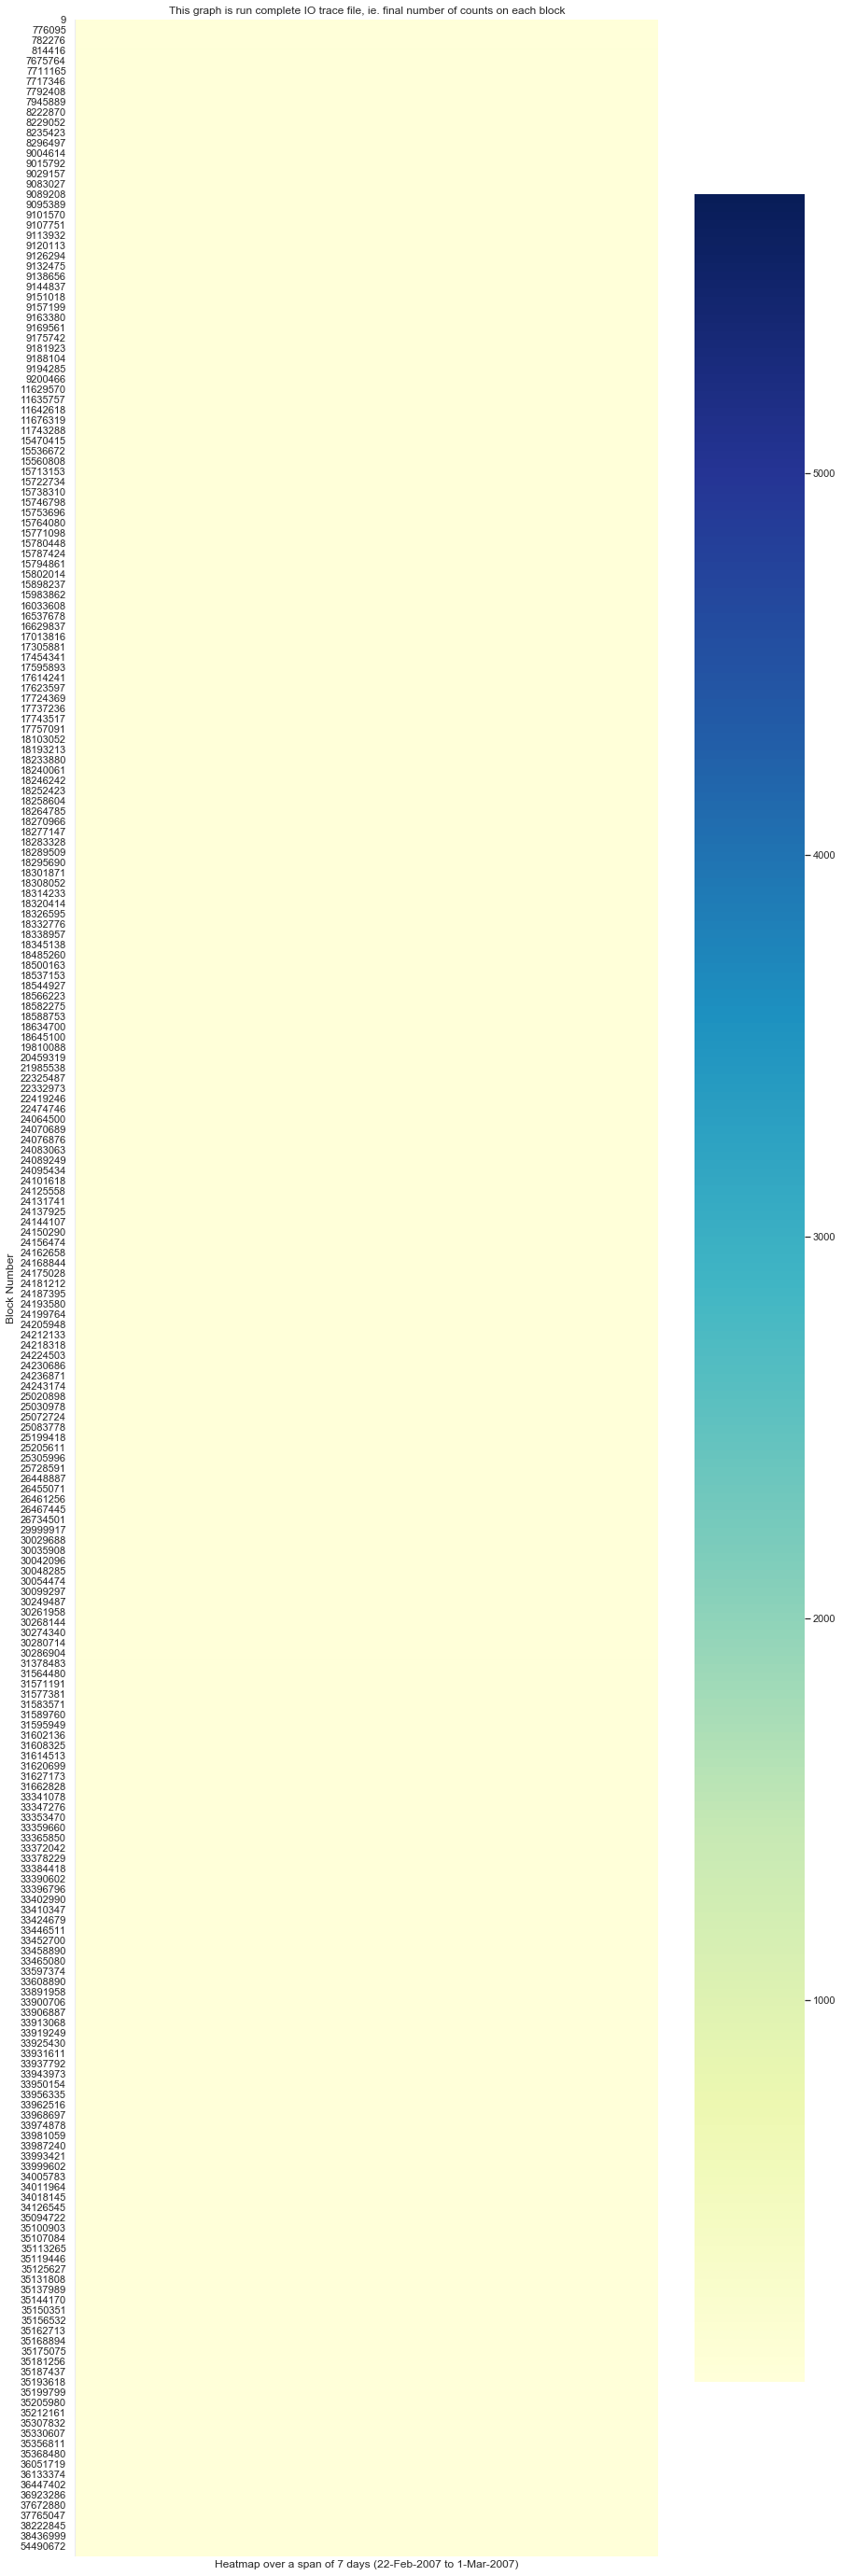

In [4]:
sns.set(rc={'figure.figsize':(14,50)})
heatmap = sns.heatmap(sorted_df, cmap="YlGnBu", xticklabels=False)
plt.xlabel('Heatmap over a span of 7 days (22-Feb-2007 to 1-Mar-2007)')
plt.ylabel('Block Number')
plt.title('This graph is run complete IO trace file, ie. final number of counts on each block')
plt.show()


In [6]:
def convert_filetime_to_datetime(ft):
    return datetime.utcfromtimestamp((ft - 116444736000000000) / 10000000)


In [7]:
# Part 2 - This is time series data



# Reset all the values to zero
# new_block_dict = dict.fromkeys(sorted_block_counter_dict, 0)

set_pivot_timer = convert_filetime_to_datetime(data.Timestamp[0])
set_hours = 1
result_df = pd.DataFrame()

granularity_y_axis = 1000
granularity_x_axis = 20

time_series_dict = dict.fromkeys(range(granularity_y_axis+1), 0)
flag = False
dataframe_column_count = 0

# Now keep only granularity_y_axis block_ranges on y-axis for better visualisation
block_range_size = sorted_df.index[-1] // granularity_y_axis


for row in data.itertuples():
    
    # print (type(convert_filetime_to_datetime(row.Timestamp)), convert_filetime_to_datetime(row.Timestamp))
    

    
    # Time visualisation can be seen in above print statement - Collect trace map for every 12hrs
    current_io_time = convert_filetime_to_datetime(row.Timestamp)
    if abs(current_io_time - set_pivot_timer) > timedelta(hours=set_hours):
        # 6 hours limit crossed, set a flag and record new entries
        flag = True
        df = pd.DataFrame.from_dict(time_series_dict, orient='index')
        result_df[dataframe_column_count] = df[0].values
        
        # update pivot timer to current one
        set_pivot_timer = current_io_time
        print ("set_pivot_timer", set_pivot_timer)
        
        dataframe_column_count += 1
        
        
        
        
        
    # Reintialize dict if just copied to dataframe    
    if flag == True:
        time_series_dict = dict.fromkeys(range(granularity_y_axis + 1), 0)
        flag = False
    
    
    
    
    
    # taking block size = 4KB    
    block_index = row.Offset // 4096
    # using offset iterate over the next blocks
    next_blocks_count = row.Size // 4096

    
    
    
    # Increment next blocks counter -------
    for i in range(0, next_blocks_count):
        time_series_dict[(block_index+i) // block_range_size] += 1
        
        
        
        
#     flag = False
    # No of time periods defined here
    if dataframe_column_count > granularity_x_axis:
        break

        
        
# loop ended, copy last time period data
if flag == False and dataframe_column_count <= granularity_x_axis:
    df = pd.DataFrame.from_dict(time_series_dict, orient='index')
    result_df[dataframe_column_count] = df[0].values
        
print (result_df)

set_pivot_timer 2007-02-22 18:04:13.598695
set_pivot_timer 2007-02-22 19:04:16.086695
set_pivot_timer 2007-02-22 20:07:36.010154
set_pivot_timer 2007-02-23 00:39:50.430770
set_pivot_timer 2007-02-23 01:39:50.608581
set_pivot_timer 2007-02-23 03:48:32.760537
set_pivot_timer 2007-02-23 05:45:26.254078
set_pivot_timer 2007-02-23 07:49:04.809193
set_pivot_timer 2007-02-23 08:53:10.048487
set_pivot_timer 2007-02-23 10:00:28.569566
set_pivot_timer 2007-02-23 11:00:39.634325
set_pivot_timer 2007-02-23 12:00:39.636025
set_pivot_timer 2007-02-23 13:01:28.137136
set_pivot_timer 2007-02-23 14:01:46.669436
set_pivot_timer 2007-02-23 15:02:17.156737
set_pivot_timer 2007-02-23 16:02:36.849470
set_pivot_timer 2007-02-23 17:05:11.721111
set_pivot_timer 2007-02-23 18:05:11.767341
set_pivot_timer 2007-02-23 19:20:34.644765
set_pivot_timer 2007-02-23 20:36:46.840887
set_pivot_timer 2007-02-23 21:54:11.802683
      0   1   2   3   4   5   6   7   8   9   ...  11  12  13  14  15  16  17  \
0      0   0   0

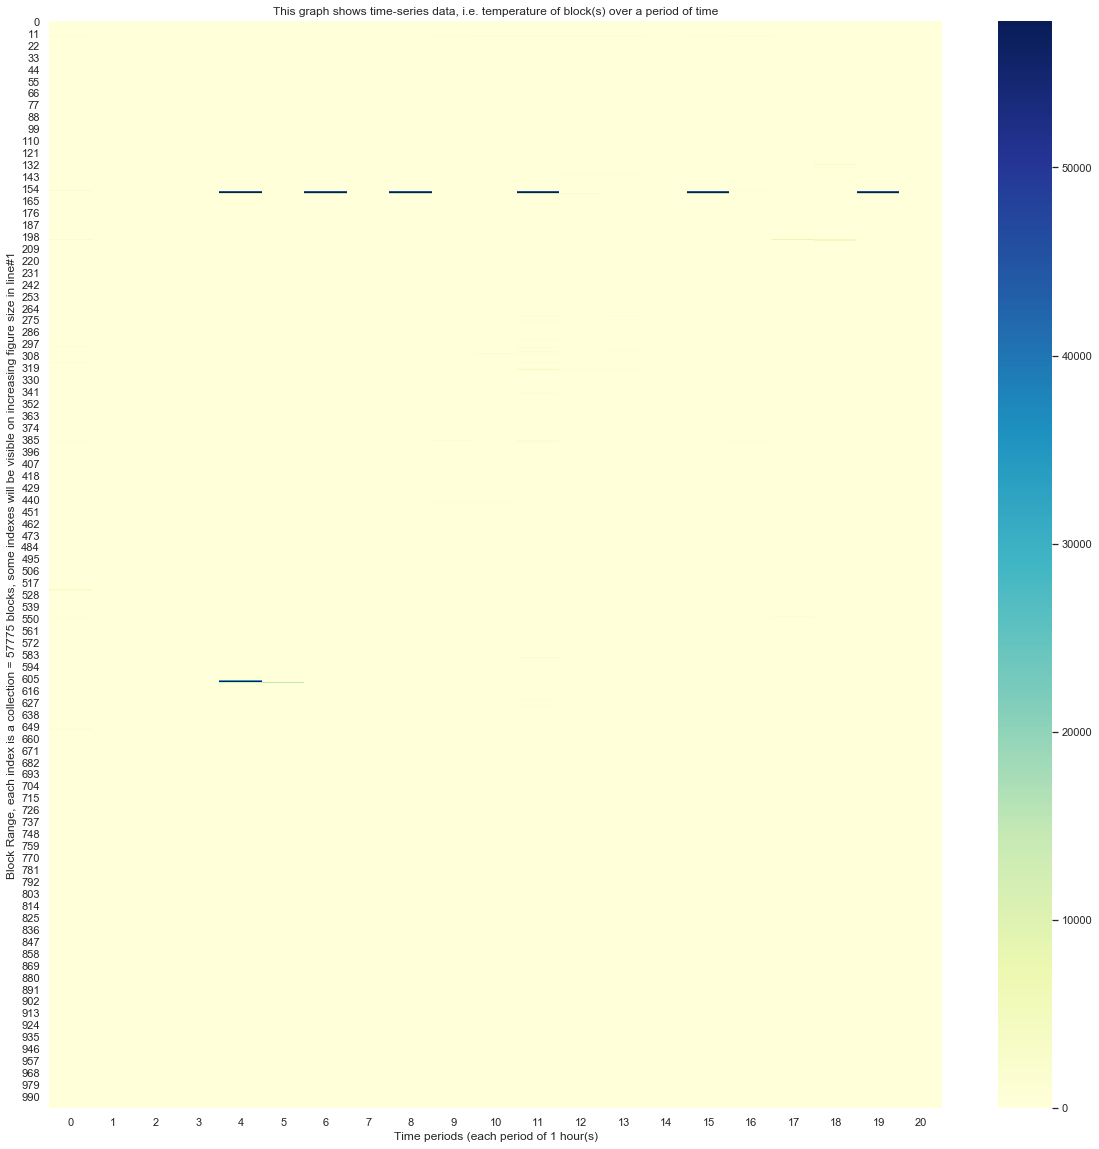

In [8]:
sns.set(rc={'figure.figsize':(20,20)})
heatmap = sns.heatmap(result_df, cmap="YlGnBu")
plt.xlabel('Time periods (each period of %s hour(s)' % set_hours)
plt.ylabel('Block Range, each index is a collection = %d blocks, some indexes will be visible on increasing figure size in line#1' % block_range_size)

plt.title('This graph shows time-series data, i.e. temperature of block(s) over a period of time')
plt.show()


In [11]:
print("Start time - ", convert_filetime_to_datetime(data.Timestamp[0]))
print("End time - ", convert_filetime_to_datetime(data.Timestamp[2244643]))
print(len(block_counter_dict) // 100)


Start time -  2007-02-22 17:00:02.440845
End time -  2007-03-01 16:59:59.736612
15266


In [12]:
sorted_df.index[-1]

57775841